In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using MLDataUtils
using Test
using ProgressMeter

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/aQmWx/src/RecipesBase.jl:116


In [4]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [5]:
Ne = 1000
Nx = 2
m = 30

X = sample_banana(Ne);

In [6]:
M = HermiteMap(m, X; diag = true);

In [7]:
optimize(M, X, "kfold"; withconstant = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


HermiteMap(30, 2, LinearTransform(2, [-0.034671789962639116, 0.9578320614597222], [0.9930819094066514 0.0; 0.0 1.7320498924994054], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 12 active features
])

In [8]:
MpushX = evaluate(M, X)

2×1000 Array{Float64,2}:
 0.500833    0.979401  -1.27372   …  0.157624  -1.75868    -0.51929
 0.0138016  -0.592794  -0.290278     0.170859  -0.0163249   1.56547

In [9]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [155]:
Nlog = 300
logbanana = zeros(Nlog, Nlog)
logbanana_x = zeros(Nlog)
logbanana_y = zeros(Nlog)
logbanana_approx = zeros(Nlog, Nlog)

lognormal = zeros(Nlog, Nlog)

a = 0.0
b = 0.95
c = 0.05


xrange = range(-5.0; stop = 5.0, length = Nlog)
yrange = range(-4.0; stop = 10.0, length = Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y], a = a, b = b, c = c)
        logbanana_x[i] = pdf(Normal(), a + b*x)
        logbanana_y[j] = pdf(Normal(), y - c*x^2)
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


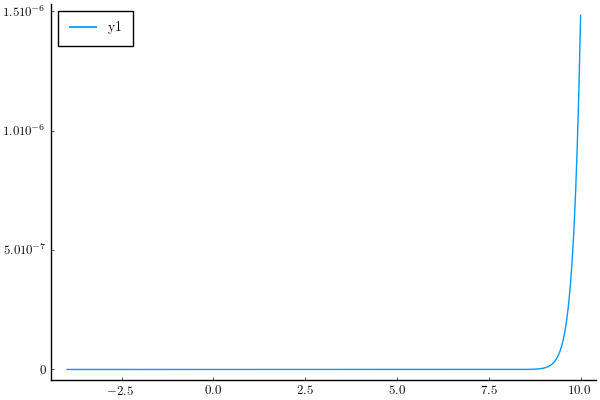

In [147]:
plot(yrange, logbanana_y)

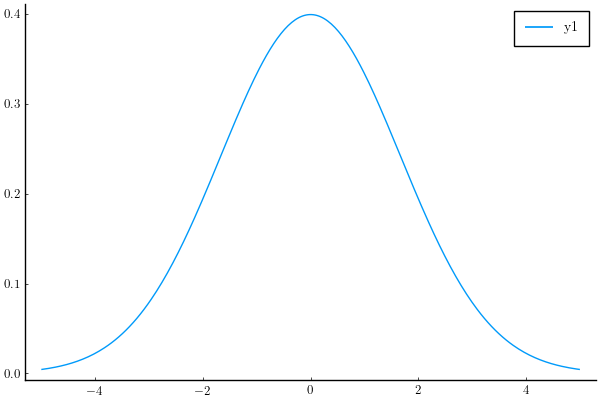

In [148]:
plot(xrange, logbanana_x)

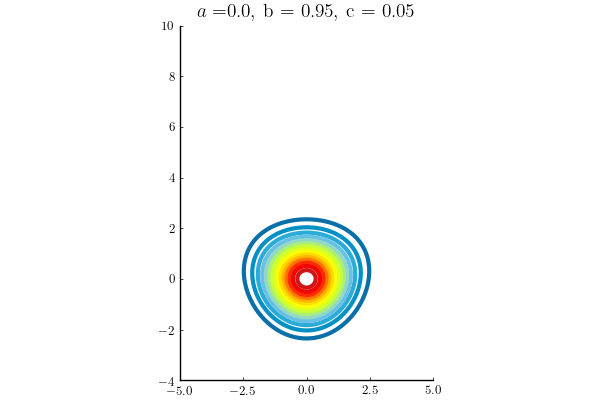

In [156]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
# savefig("banana_3.pdf")

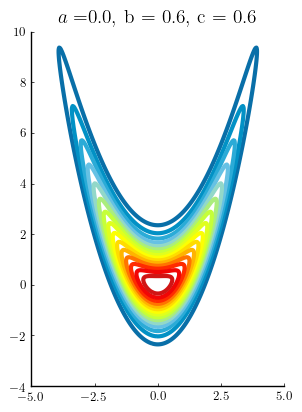

In [127]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("banana_2.pdf")

In [ ]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("banana_2.pdf")

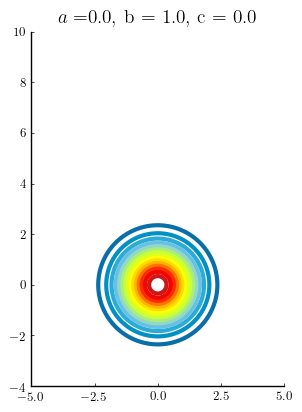

In [133]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1, 
#          levels = 20,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("gaussian.pdf")

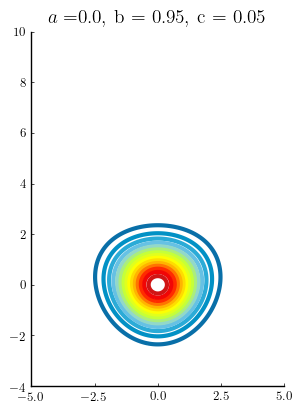

In [157]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("gaussian_approx.pdf")

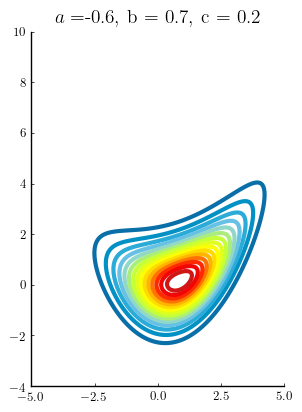

In [135]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1, 
#          clim = (0.05, Inf),
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("banana_1.pdf")

In [112]:
norm(exp.(logbanana)' - exp.(logbanana_approx)')/norm(exp.(logbanana)')

0.683932539316116

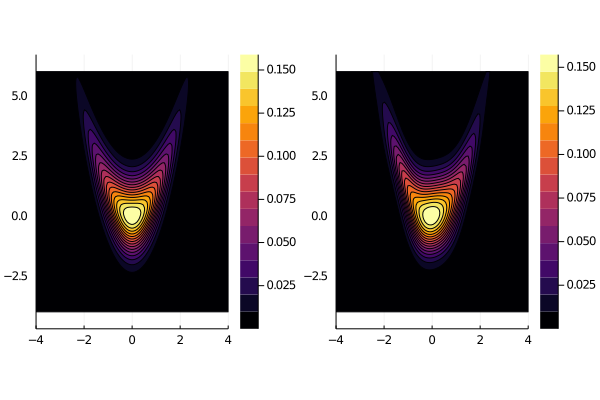

In [46]:
plt = plot(layout = grid(1,2))
contourf!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contourf!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

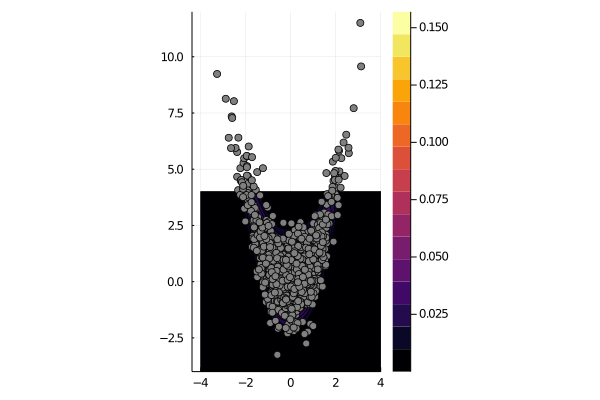

In [21]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf), ylim = (-4, 12))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey, ratio = 1)

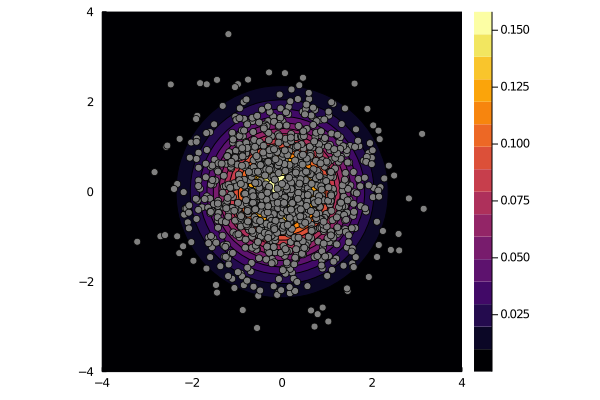

In [22]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [23]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 -0.0048777388265290045
  0.00011520151984957305

In [24]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
  0.999968     -0.000653141
 -0.000653141   0.999085